1659
1562
After Scaling :
+------+------+----------+------------+-------------+-----------------+
|  Year|Length|Popularity|Year_Buckets|Length_Scaled|Popularity_Scaled|
+------+------+----------+------------+-------------+-----------------+
|1990.0| 111.0|      68.0|         7.0|        0.533|             0.77|
|1991.0| 113.0|      68.0|         7.0|        0.544|             0.77|
|1983.0| 104.0|      79.0|         6.0|        0.494|            0.897|
|1979.0| 122.0|       6.0|         5.0|        0.594|            0.057|
|1978.0|  94.0|      14.0|         5.0|        0.439|            0.149|
|1983.0| 140.0|      68.0|         6.0|        0.694|             0.77|
|1984.0| 101.0|      14.0|         6.0|        0.478|            0.149|
|1989.0|  99.0|      28.0|         6.0|        0.467|             0.31|
|1985.0| 104.0|       6.0|         6.0|        0.494|            0.057|
|1990.0| 149.0|      32.0|         7.0|        0.744|            0.356|
+------+------+----------+------------

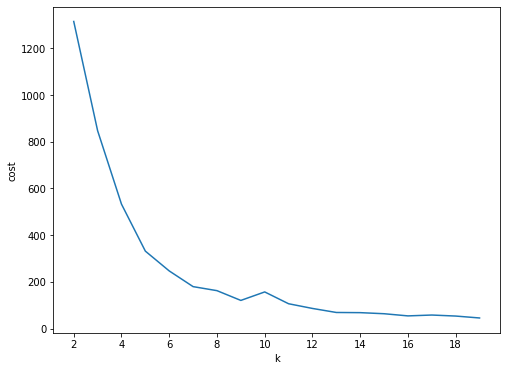

Cluster Centers: 
[6.06305506 0.49415275 0.47836057]
[1.41916168 0.40892814 0.54327545]
[3.5464684  0.51795539 0.49130855]
+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         2|
|         0|
|         2|
|         0|
|         0|
|         1|
|         2|
|         0|
+----------+
only showing top 20 rows



<Figure size 432x288 with 0 Axes>

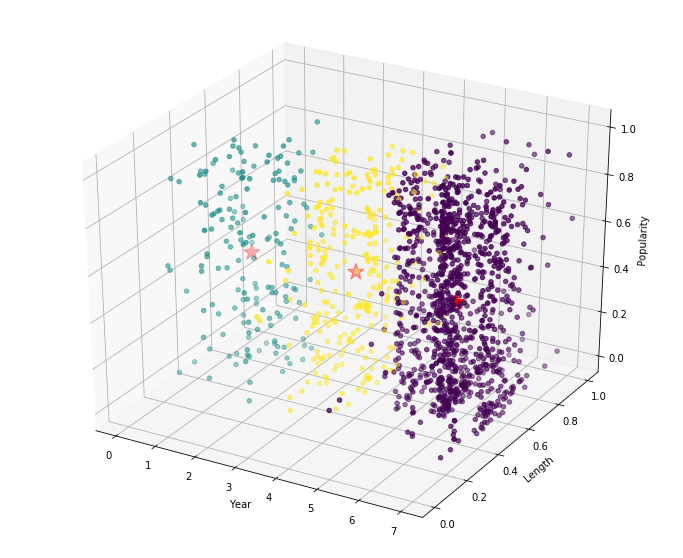

In [238]:
import findspark
findspark.init()
from pyspark.sql import HiveContext
from pyspark.ml.feature import Imputer

import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import lower, col , avg,min,max,mean
from statistics import pvariance
import sys

import pandas as pd
import numpy as np
from scipy import stats
np.set_printoptions(threshold=sys.maxsize)
from warnings import filterwarnings 

# create the session
conf = SparkConf().setMaster("local").setAppName("Assignment3.3")
# create the context
sc = SparkContext.getOrCreate(conf=conf)
sqlContext = HiveContext(sc)

spark = SparkSession.builder.getOrCreate()
from pyspark import SparkFiles
import pyspark.sql.functions as F
from numpy import array
from math import sqrt
import copy
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
import seaborn as sbs
from matplotlib.ticker import MaxNLocator
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import DenseVector


data_path = ""
df = sqlContext.read.csv(SparkFiles.get("/Users/Amara/Movies.csv"), header=True, inferSchema= True, sep=";")
dff = df

dff = dff.withColumn("Length", F.when(dff.Length.isNull(), F.lit(0)).otherwise(dff.Length))
dff = dff.withColumn("Popularity", F.when(dff.Popularity.isNull(), F.lit(0)).otherwise(dff.Popularity))
dff = dff.withColumn("Year", F.when(dff.Year.isNull(), F.lit(0)).otherwise(dff.Year))
print(dff.count())

dff = dff.filter((dff.Length > 5)  & (dff.Length < 198) & (dff.Year > 1925))

print(dff.count())

columns = dff.select('Year','Length','Popularity')
COL = columns.rdd.map(lambda x:x)
data = np.array(COL.collect())


dff = dff.withColumn("Year", F.when(dff.Year==0, np.mean(data[:,0])).otherwise(dff.Year))
dff = dff.withColumn("Length", F.when(dff.Length==0, np.mean(data[:,1])).otherwise(dff.Length))
dff = dff.withColumn("Popularity", F.when(dff.Popularity==0, np.mean(data[:,2])).otherwise(dff.Popularity))


drop_name =  ['Title','Genre', 'Actor', 'Actress', 'Director','Awards','Image']
dfp=dff.drop(*drop_name)

bucketizer = Bucketizer(splits=[ 1920, 1930, 1940, 1950, 1960, 1970 , 1980 ,1990, 2000, float('Inf') ],inputCol="Year", outputCol="Year_Buckets")
dfp = bucketizer.setHandleInvalid("keep").transform(dfp)
#Normalize Length and Popularity

# Iterating over columns to be scaled

unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

for i in ["Length","Popularity"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    dfp = pipeline.fit(dfp).transform(dfp).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
dfp.show(10)
#input_data = dfp.rdd.map(lambda x: (x[3], DenseVector(x[3:5])))
#input_data.take(5)
FEATURES_COL = ['Year_Buckets','Length_Scaled','Popularity_Scaled']


vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(dfp).select('features')
df_kmeans.show()


cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("features")\

    model = kmeans.fit(df_kmeans)
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
plt.savefig('elbow.png')

k = 3
#KMeans().setMaxIter(1)
kmeans = KMeans().setK(k).setSeed(1).setMaxIter(20).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)
    
transformed = model.transform(df_kmeans).select('prediction')
rows = transformed.collect()

df_pred = sqlContext.createDataFrame(rows)
df_pred.show()


#df_pred = df_pred.join(dff, 'id')
df1 = df_pred.toPandas()

df2 = dfp.toPandas()

pddf_pred = pd.concat([df1, df2], axis=1, join='inner')
pddf_pred.head()
C1 = centers
C = np.array(C1)

threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.Year_Buckets, pddf_pred.Length_Scaled, pddf_pred.Popularity_Scaled, c=pddf_pred.prediction)

#threedee.scatter(pddf_pred.Year, pddf_pred.Length, pddf_pred.Popularity, c=pddf_pred.prediction)
threedee.scatter(C[:,0], C[:,1], C[:,2], marker='*', c='#FF0000', s=300)
threedee.set_xlabel('Year')
threedee.set_ylabel('Length')
threedee.set_zlabel('Popularity')
plt.show()




In [235]:
#part b

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce  # For Python 3.x

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

def optimal_k(df_in,index_col,k_min, k_max,num_runs):
   
    silh_lst = []
    k_lst = np.arange(k_min, k_max+1)

    r_table = df_in.select(index_col).toPandas()
    r_table = r_table.set_index(index_col)
    centers = pd.DataFrame()

    for k in k_lst:
        silh_val = []
        for run in np.arange(1, num_runs+1):

            # Trains a k-means model.
            kmeans = KMeans()\
                    .setK(k)\
                    .setSeed(int(np.random.randint(100, size=1)))
            model = kmeans.fit(df_in)

            # Make predictions
            predictions = model.transform(df_in)
            r_table['cluster_{k}_{run}'.format(k=k, run=run)]= predictions.select('prediction').toPandas()

            # Evaluate clustering by computing Silhouette score
            evaluator = ClusteringEvaluator()
            silhouette = evaluator.evaluate(predictions)
            silh_val.append(silhouette)

        silh_array=np.asanyarray(silh_val)
        silh_lst.append(silh_array.mean())

    silhouette = pd.DataFrame(list(zip(k_lst,silh_lst)),columns = ['k', 'silhouette'])

    return k_lst[np.argmax(silh_lst, axis=0)], silhouette , r_table
    
    
k, silh_lst, r_table = optimal_k(df_kmeans,"features",3, 12 ,10)

spark.createDataFrame(silh_lst).show()



+---+-------------------+
|  k|         silhouette|
+---+-------------------+
|  3|0.27365380894392943|
|  4|0.29493198209510896|
|  5|0.23649264832731703|
|  6|0.25179356814644016|
|  7|0.30080528347212904|
|  8|0.21323812855433705|
|  9|0.22564633158881744|
| 10|0.22613132663657928|
| 11| 0.2210366199554965|
| 12|0.20529200158023214|
+---+-------------------+



In [ ]:
#so choose k = 9


+---------------+--------------------+------+-------------+----------------+--------------+---------------------+------------------------+----------------------+--------------------+
|          Genre|            Director|Awards|Genre_indexed|Director_indexed|Awards_indexed|Genre_indexed_encoded|Director_indexed_encoded|Awards_indexed_encoded|            features|
+---------------+--------------------+------+-------------+----------------+--------------+---------------------+------------------------+----------------------+--------------------+
|         Horror|   Cronenberg, David|    No|          4.0|            16.0|           0.0|        (9,[4],[1.0])|        (593,[16],[1.0])|         (1,[0],[1.0])|(603,[4,25,602],[...|
|         Action|     Lester, Richard|    No|          1.0|            62.0|           0.0|        (9,[1],[1.0])|        (593,[62],[1.0])|         (1,[0],[1.0])|(603,[1,71,602],[...|
|          Drama|    Malick, Terrence|    No|          0.0|           309.0|         

+----------+
|prediction|
+----------+
|         3|
|         5|
|         1|
|         5|
|         5|
|         1|
|         1|
|         1|
|         9|
|         1|
|         0|
|         1|
|         0|
|         0|
|         1|
|         3|
|         1|
|         5|
|         6|
|         5|
+----------+
only showing top 20 rows

        Genre                  Director Awards  Genre_indexed  \
0      Horror         Cronenberg, David     No            4.0   
1      Action           Lester, Richard     No            1.0   
2       Drama          Malick, Terrence     No            0.0   
3      Action                Glen, John     No            1.0   
4      Action  Loma, Jos� Antonio de la     No            1.0   
...       ...                       ...    ...            ...   
1260  Western         Hitchcock, Alfred     No            2.0   
1261  Western         Hitchcock, Alfred     No            2.0   
1262   Action         Hitchcock, Alfred     No            1.0   
1263   Actio

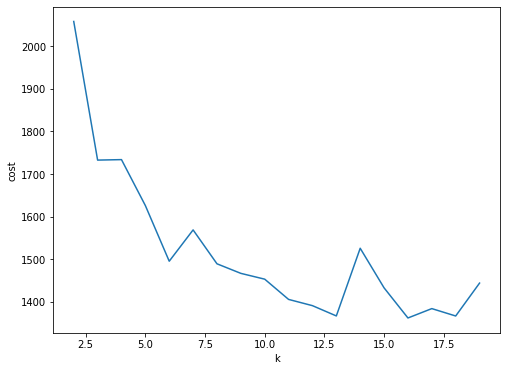

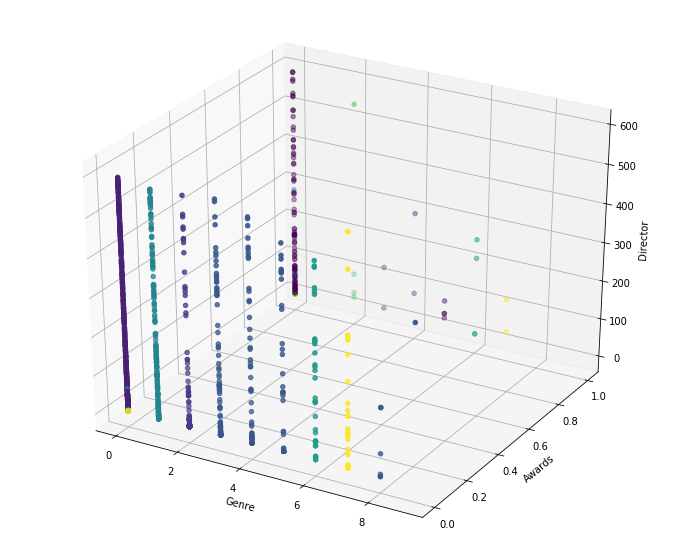

In [263]:
#b
dfb = df
director = dfb.groupBy('Director').count().orderBy(col('count').desc()).limit(2).collect()[1]['Director']
genre = dfb.groupBy('Genre').count().orderBy(col('count').desc()).limit(1).collect()[0]['Genre']


dfb= dfb.fillna({'Director': director})
dfb= dfb.fillna({'Genre': 'Others'})
dfb = dfb.filter((dfb.Genre != 'Others')  & (dfb.Genre != 'Crime') & (dfb.Genre != 'Comedy') &
                (dfb.Genre != 'Fantasy')  & (dfb.Genre != 'Romance') & (dfb.Genre != 'Adventure') &
                (dfb.Genre != 'WEsterns'))

def get_feature_vector(df,categoricalCols):
   
    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # get feature vector using one hot encoding
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                , outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    # get feature vector without one hot encoding
    '''assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers]
                                , outputCol="features")
    pipeline = Pipeline(stages=indexers  + [assembler])'''
    model=pipeline.fit(df)
    data = model.transform(df)
    data.show()
    return data

drop_name =  ['Title','Year', 'Actor', 'Actress', 'Popularity','Length','Image']
dfb=dfb.drop(*drop_name)


CAT_COL = ['Genre','Director','Awards']
df_kmeans = get_feature_vector( dfb, CAT_COL)
df_kmeans.select('features').show()

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later
    
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')


k = 12
#KMeans().setMaxIter(1)
kmeans = KMeans().setK(k).setSeed(1).setMaxIter(20).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)  



transformed = model.transform(df_kmeans).select('prediction')
rows = transformed.collect()

df_pred = sqlContext.createDataFrame(rows)
df_pred.show()


#df_pred = df_pred.join(dff, 'id')
df1 = df_pred.toPandas()

df2 = df_kmeans.toPandas()
print(df2)
pddf_pred = pd.concat([df1, df2], axis=1, join='inner')
pddf_pred.head()

C1 = centers
C = np.array(C1)

threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter( pddf_pred.Genre_indexed, pddf_pred.Awards_indexed, pddf_pred.Director_indexed,  c=pddf_pred.prediction)

#threedee.scatter(pddf_pred.Year, pddf_pred.Length, pddf_pred.Popularity, c=pddf_pred.prediction)
#threedee.scatter(C[:,0], C[:,1], C[:,2], marker='*', c='#FF0000', s=400)
threedee.set_xlabel('Genre')
threedee.set_ylabel('Awards')
threedee.set_zlabel('Director')
plt.show()




In [245]:
k, silh_lst, r_table = optimal_k(df_kmeans,"features",5, 12 ,10)

spark.createDataFrame(silh_lst).show()


+---+------------------+
|  k|        silhouette|
+---+------------------+
|  5|0.7924767447258925|
|  6|0.7816955128410198|
|  7|0.7778883055387232|
|  8|0.7699452607584605|
|  9|0.7609951021892034|
| 10|0.7552267036187815|
| 11|0.7523555690971231|
| 12| 0.750625985206234|
+---+------------------+

